Nós e deslocamentos:
  x     y       ux        uy
0.0 0.000 0.000000  0.000000
1.0 0.000 0.000007  0.000000
0.5 0.866 0.000003 -0.000018

Elementos e forças axiais:
 elemento  nó_i  nó_j        L  N (força axial)
        0     0     1 1.000000      2886.836028
        1     0     2 0.999978     -5773.545033
        2     1     2 0.999978     -5773.545033


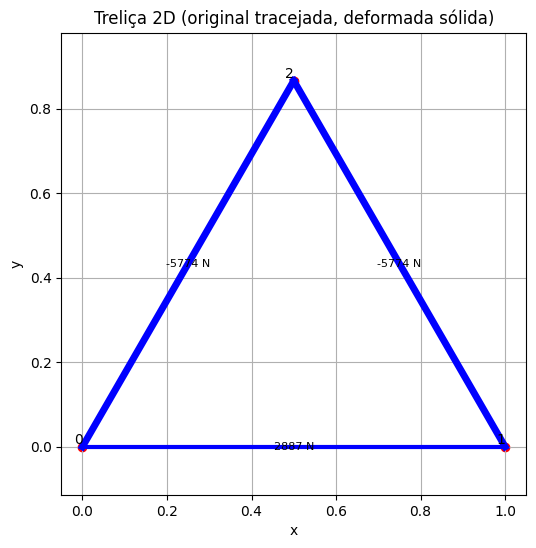

In [1]:
# ============================================
# Análise de Treliça 2D pelo Método da Rigidez
# Código pronto para rodar no Google Colab
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1) Dados do problema ---
E = 210e3       # Módulo de Young (MPa)
A = 2000.0      # Área da seção transversal (mm^2)

# Coordenadas dos nós: [x, y]
nodes = np.array([
    [0.0, 0.0],    # nó 0
    [1.0, 0.0],    # nó 1
    [0.5, 0.866],  # nó 2
])

n_nodes = nodes.shape[0]

# Conectividade dos elementos: (nó_i, nó_j, A, E)
elements = [
    (0, 1, A, E),
    (0, 2, A, E),
    (1, 2, A, E),
]

# Graus de liberdade (2 por nó: ux, uy)
dof_per_node = 2
n_dof = n_nodes * dof_per_node

# Vetor de forças globais
F = np.zeros(n_dof)
F[2*2 + 1] = -10000.0  # carga vertical -10 kN no nó 2

# Restrições (condições de contorno): {grau de liberdade: valor}
# nó 0: fixo (ux=0, uy=0)
# nó 1: apoios deslizante (uy=0, ux livre)
fixed_dofs = {
    0: 0.0,
    1: 0.0,
    2*1+1: 0.0,
}

# --- 2) Função para rigidez local ---
def element_stiffness_matrix(xi, xj, A, E):
    dx = xj - xi
    L = np.linalg.norm(dx)
    c = dx[0] / L
    s = dx[1] / L
    k_local = (A * E / L) * np.array([
        [ c*c,  c*s, -c*c, -c*s],
        [ c*s,  s*s, -c*s, -s*s],
        [-c*c, -c*s,  c*c,  c*s],
        [-c*s, -s*s,  c*s,  s*s],
    ])
    return k_local, L, c, s

# --- 3) Montagem da matriz global ---
K = np.zeros((n_dof, n_dof))
element_data = []
for idx, (i, j, area, Eelem) in enumerate(elements):
    xi, xj = nodes[i], nodes[j]
    k_e, L, c, s = element_stiffness_matrix(xi, xj, area, Eelem)
    dofs = [2*i, 2*i+1, 2*j, 2*j+1]
    for a in range(4):
        for b in range(4):
            K[dofs[a], dofs[b]] += k_e[a, b]
    element_data.append({"i": i, "j": j, "L": L, "c": c, "s": s, "A": area, "E": Eelem})

# --- 4) Aplicação de restrições ---
all_dofs = np.arange(n_dof)
free_dofs = np.array([d for d in all_dofs if d not in fixed_dofs.keys()], dtype=int)

K_ff = K[np.ix_(free_dofs, free_dofs)]
F_f = F[free_dofs]

# --- 5) Resolução do sistema ---
u = np.zeros(n_dof)
u_free = np.linalg.solve(K_ff, F_f)
u[free_dofs] = u_free

# Reações
reactions = {dof: K[dof, :].dot(u) - F[dof] for dof in fixed_dofs.keys()}

# --- 6) Esforços axiais nos elementos ---
element_forces = []
for ed in element_data:
    i, j = ed["i"], ed["j"]
    dofs = [2*i, 2*i+1, 2*j, 2*j+1]
    u_e = u[dofs]
    L, c, s = ed["L"], ed["c"], ed["s"]
    T = np.array([-c, -s, c, s])
    axial_force = ed["A"] * ed["E"] / L * T.dot(u_e)
    element_forces.append(axial_force)

# --- 7) Resultados em tabelas ---
df_nodes = pd.DataFrame(nodes, columns=["x", "y"])
df_nodes["ux"] = u.reshape(-1,2)[:,0]
df_nodes["uy"] = u.reshape(-1,2)[:,1]

df_elements = pd.DataFrame([
    {"elemento": idx, "nó_i": e[0], "nó_j": e[1], "L": d["L"], "N (força axial)": element_forces[idx]}
    for idx, (e, d) in enumerate(zip(elements, element_data))
])

print("Nós e deslocamentos:")
print(df_nodes.to_string(index=False))
print("\nElementos e forças axiais:")
print(df_elements.to_string(index=False))

# --- 8) Plot da treliça ---
scale = 1.0  # fator de amplificação visual
deformed_nodes = nodes + scale * u.reshape(-1,2)

plt.figure(figsize=(6,6))
# treliça original (tracejada)
for (i, j, *_ ) in elements:
    xi, xj = nodes[i], nodes[j]
    plt.plot([xi[0], xj[0]], [xi[1], xj[1]], 'k--', linewidth=1)

# treliça deformada (sólida, com espessura proporcional ao esforço)
max_force = max(abs(np.array(element_forces))) if element_forces else 1.0
for idx, (i, j, *_ ) in enumerate(elements):
    xi, xj = deformed_nodes[i], deformed_nodes[j]
    lw = 1.0 + 4.0 * abs(element_forces[idx]) / max_force
    plt.plot([xi[0], xj[0]], [xi[1], xj[1]], 'b-', linewidth=lw)
    xm, ym = 0.5*(xi[0]+xj[0]), 0.5*(xi[1]+xj[1])
    plt.text(xm, ym, f"{element_forces[idx]:.0f} N", fontsize=8, ha='center', va='center')

plt.scatter(deformed_nodes[:,0], deformed_nodes[:,1], c='red')
for i, (x, y) in enumerate(deformed_nodes):
    plt.text(x, y, f"{i}", fontsize=10, va='bottom', ha='right')

plt.title("Treliça 2D (original tracejada, deformada sólida)")
plt.axis('equal'); plt.grid(True); plt.xlabel('x'); plt.ylabel('y')
plt.show()
